In [1]:
import numpy as np

## Indexing

In [35]:
test_block = np.random.randint(0,2,(3,3))
test_block

array([[0, 0, 0],
       [1, 1, 0],
       [1, 1, 0]])

In [36]:
print(first_idx := (test_block != 0).argmax())

3


In [38]:
test_block.shape

(3, 3)

x,y = int(first_idx / test_block.shape[1]), first_idx % test_block.shape[0]
print(x,y)
test_block[x][y]

In [42]:
test_block = np.random.randint(0,1,(3,3))
test_block

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [43]:
print(first_idx := (test_block != 0).argmax())

0


In [44]:
x,y = int(first_idx / test_block.shape[1]), first_idx % test_block.shape[0]
print(x,y)
test_block[x][y]

0 0


0

## Metric test

In [1]:
from typing import List
from common.phenotype_framework import PhenotypeFramework as pf
from revolve2.genotypes.cppnwin._genotype import Genotype
from revolve2.genotypes.cppnwin.modular_robot.body_genotype_v1 import develop_v1

def get_population(genotypes: List[Genotype | str]) -> List[float]:
    """
    calculates novelty across population.
    :param genotypes: List[Genotype | str] --> list of genotypes for population.
    :param normalization: None -> no normalization | "clipping" -> between 0,1 | "log" -> log of x
    :param test: which test to compare histograms (chi-squared, yates-chi-squared)
    :return: List[float] novelty rate per individual
    """
    amt_instances = len(genotypes)

    genotypes = [genotype if not isinstance(genotype, str) else pf.deserialize(genotype) for genotype in genotypes]
    bodies = [develop_v1(genotype) for genotype in genotypes]

    coords = [pf._body_to_sorted_coordinates(body) for body in bodies]
    coords = [pf._coordinates_pca_change_basis(coord) for coord in coords] # PCA change of basis -> orientation of variance/ covariance

    brick_hists, hinge_hists = [None] * amt_instances, [None] * amt_instances

    i = 0
    for coord in coords:
        brick_mag, brick_orient = pf._coordinates_to_magnitudes_orientation(coord[0])
        brick_hists[i] = pf._gen_gradient_histogram(magnitudes=brick_mag,
                                                     orientations=brick_orient)

        hinge_mag, hinge_orient = pf._coordinates_to_magnitudes_orientation(coord[1])
        hinge_hists[i] = pf._gen_gradient_histogram(magnitudes=hinge_mag,
                                                     orientations=hinge_orient)
        i += 1
    return brick_hists, hinge_hists

def get_novelty_population(brick_hists, hinge_hists) -> List[float]:
    amt_instances = len(brick_hists)

    brick_novelty_scores = [0] * amt_instances
    hinge_novelty_scores = [0] * amt_instances
    for i in range(amt_instances - 1):
        for j in range(i + 1, amt_instances):
            brick_score = pf._compare_hist(brick_hists[i], brick_hists[j])
            brick_novelty_scores[i] += brick_score
            brick_novelty_scores[j] += brick_score

            hinge_score = pf._compare_hist(hinge_hists[i], hinge_hists[j])
            hinge_novelty_scores[i] += hinge_score
            hinge_novelty_scores[j] += hinge_score


    novelty_scores = [(b_score + h_score) / 2
                      for b_score, h_score in zip(brick_novelty_scores, hinge_novelty_scores)]

    mscore = max(novelty_scores)
    novelty_scores = [score/mscore if score > 0. else 0. for score in novelty_scores]
    # scaling because the min novelty is 0 in theory --> some populations can have
    return novelty_scores


In [3]:

import importlib
import matplotlib.pyplot as plt
from common import compare_histograms as ch
import _load_db

importlib.reload(_load_db)
importlib.reload(ch)
%matplotlib inline

In [4]:
genotypes = _load_db.load_db("experiments/database", )
selection = genotypes.serialized_multineat_genome.values

In [5]:
brick_hists, hinge_hists = get_population(selection)

IndexError: list index out of range

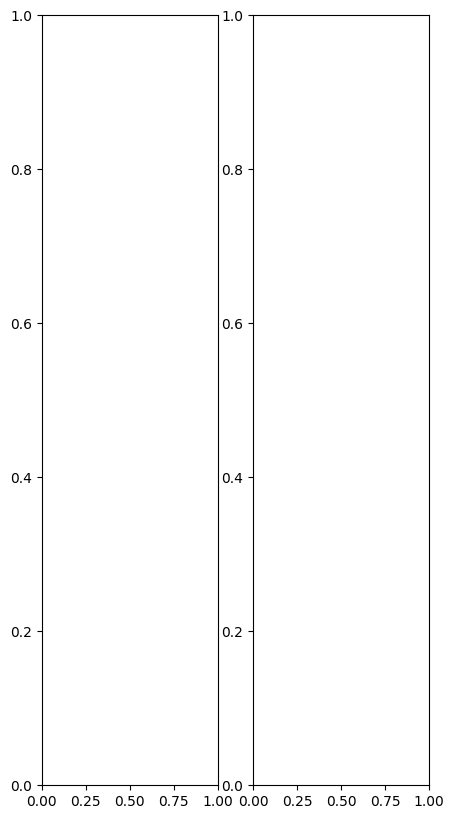

In [8]:
for bhist, hhist in zip(brick_hists, hinge_hists):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize = (5,10))
    ax1.imshow(bhist)
    ax2.imshow(hhist)
    plt.show()

In [6]:
print(get_novelty_population(brick_hists, hinge_hists))

[0.7385749052809095, 0.7944115514011387, 1.0]
